# Lab2 - TSP EA solution

In [1]:
from itertools import combinations
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass
from tqdm.auto import tqdm

c:\Users\loren\OneDrive\Desktop\CI repo\labs\Lab1\CI2024_lab1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CITIES = pd.read_csv('cities/russia.csv', header=None, names=['name', 'lat', 'lon'])

POPULATION_SIZE = len(CITIES)*5
OFFSPRING_SIZE = int(POPULATION_SIZE*0.5)
MAX_GENERATIONS = 200

# Reproducible random
rng = np.random.Generator(np.random.PCG64([POPULATION_SIZE, OFFSPRING_SIZE, MAX_GENERATIONS]))

In [3]:
# Save for each couple save -> ( distance, index of compared city )
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)), dtype=tuple)
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c2.Index)
    DIST_MATRIX[c2.Index, c1.Index] = (geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km, c1.Index)

## Helper Functions

In [4]:
def cost(path):
    circular_path = path + [path[0]]
    tot_dist = 0
    for i in range(len(circular_path)-1):
        tot_dist += DIST_MATRIX[circular_path[i],circular_path[i+1]][0]
    return tot_dist


In [5]:
def print_path(path):
    circular_path = path + [path[0]]
    print("Path:")
    for i in range(len(circular_path)-1):
        print(f"{CITIES.at[circular_path[i],'name']} -> {CITIES.at[circular_path[i+1],'name']} ({DIST_MATRIX[circular_path[i],circular_path[i+1]][0]:.2f}km)")

    print(f"\nNumber of steps: {len(circular_path)-1} , Total lenght: {cost(path):.2f} km")


In [6]:
def visualize_path(path):
    circular_path = path + [path[0]]
    x_coordinates = [CITIES.at[i,'lon'] for i in circular_path]
    y_coordinates = [CITIES.at[i,'lat'] for i in circular_path]

    plt.figure()
    plt.title("Path EA Resolution")
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.axis('equal')
    plt.plot(x_coordinates,y_coordinates,marker='o', linestyle='-', color='b')
    plt.show()

In [7]:
@dataclass
class Individual:
    genome: list
    fitness: float = None

In [8]:
def parent_selection(population):
    candidates = sorted(rng.choice(population,4), key=lambda e: e.fitness)
    
    return candidates[0], candidates[1]

In [9]:
def max_distance(path):
    circular_path = path + [path[0]]
    distances = np.zeros(len(CITIES))
    for i in range(0,len(circular_path)-1):
        distances[i] = DIST_MATRIX[circular_path[i],circular_path[i+1]][0]

    return np.argmax(distances)


In [10]:
def inverover(p1: Individual, p2: Individual):
    
    longest_dist_p2 = max_distance(p2.genome)

    index_p1 = p1.genome.index(p2.genome[longest_dist_p2])

    child_genome = p1.genome.copy()
    child_genome[index_p1:] = p1.genome[index_p1:][::-1]

    return Individual(child_genome)

    

In [11]:
def mutation(p:Individual):
    child_genome = p.genome.copy()
    x = 0
    while x < 0.7:
        longest_dist = max_distance(child_genome)
        
        exchange_i = rng.integers(0,len(CITIES)+longest_dist)
        exchange_i = exchange_i % len(CITIES)
      
        temp = child_genome[longest_dist]
        child_genome[longest_dist] = child_genome[exchange_i]
        child_genome[exchange_i] = temp
        x = rng.random()
    return Individual(child_genome)

    

In [12]:
def compute_fast_min(start):
    # Search min algorithm
    visited = np.full(len(CITIES), False)
    curr_city_i = start
    visited[curr_city_i] = True
    path = list()
    path.append(curr_city_i)

    while not np.all(visited):

        # Find the city with minimum distance and take the correspondig index to make it the next city
        next_city_tup= np.min(DIST_MATRIX[curr_city_i,np.logical_not(visited)])
        curr_city_i = next_city_tup[1]

        path.append(curr_city_i)
        visited[curr_city_i] = True
    
    return path


# EA Resolution

In [13]:
cities_idx = [i for i in range(len(CITIES))]

population = [Individual(compute_fast_min(i)) for i in range(len(CITIES))]

for i in population:
    i.fitness = cost(i.genome)

for _ in tqdm(range(MAX_GENERATIONS)):
    offspring = list()

    for _ in range(OFFSPRING_SIZE):
        
        p1,p2 = parent_selection(population)
        
        if rng.random() <0.5:
            o = inverover(p1,p2)
        else:
            o = mutation(p1)

        offspring.append(o)

    for i in offspring:
        i.fitness = cost(i.genome)

    population.extend(offspring)
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]


100%|██████████| 200/200 [01:01<00:00,  3.28it/s]


Path:
Abakan -> Novokuznetsk (285.72km)
Novokuznetsk -> Prokopyevsk (30.63km)
Prokopyevsk -> Leninsk‐Kuznetskiy (91.87km)
Leninsk‐Kuznetskiy -> Kemerovo (74.76km)
Kemerovo -> Tomsk (147.60km)
Tomsk -> Seversk (14.97km)
Seversk -> Novosibirsk (211.49km)
Novosibirsk -> Barnaul (194.50km)
Barnaul -> Biysk (132.82km)
Biysk -> Rubtsovsk (294.26km)
Rubtsovsk -> Omsk (647.47km)
Omsk -> Tobolsk (475.40km)
Tobolsk -> Tyumen (200.98km)
Tyumen -> Kurgan (189.69km)
Kurgan -> Kopeysk (236.87km)
Kopeysk -> Chelyabinsk (14.72km)
Chelyabinsk -> Miass (87.20km)
Miass -> Zlatoust (33.88km)
Zlatoust -> Pervouralsk (194.64km)
Pervouralsk -> Yekaterinburg (40.19km)
Yekaterinburg -> Kamensk‐Uralskiy (95.20km)
Kamensk‐Uralskiy -> Nizhniy Tagil (205.75km)
Nizhniy Tagil -> Perm (220.37km)
Perm -> Berezniki (159.92km)
Berezniki -> Izhevsk (353.17km)
Izhevsk -> Neftekamsk (107.05km)
Neftekamsk -> Naberezhnye Chelny (129.52km)
Naberezhnye Chelny -> Nizhnekamsk (31.95km)
Nizhnekamsk -> Almetyevsk (88.07km)
Almetye

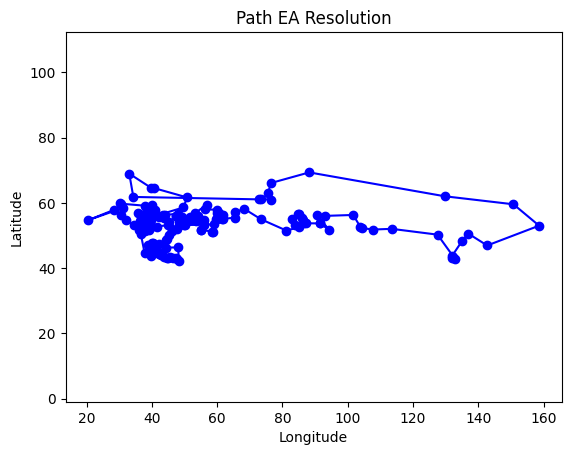

In [14]:
print_path(population[0].genome)
visualize_path(population[0].genome)